# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
Given data on power outages, it would be nice for officials to be able to predict the cause of a power outage so that energy companies and local governement can determine what equipment needs to be upgraded, if infrastructure needs to be reinforced, etc. The unique causes in the outage dataset are: severe weather, intentional attack, system operability disruption, equipment failure, public appeal, fuel supply emergency, and islanding. By being able to accurately predict the cause of the outage officials may be able to combat or at least prepare for new ones and either lessen the impact or totally stop certain power outages from happening. This will be a classification problem, and therfore I will be using accuracy as my main objective benchmark for the best model possible.

### Baseline Model
In my baseline model I included five features total: two ordinal features, 'CLIMATE.CATEGORY' and 'MONTH', two nominal features, 'CLIMATE.REGION' and 'U.S._STATE', and one quantitative feature 'OUTAGE.HOUR'. We would know this information beforehand as we use demographic and time data to predict the cause of an outage occuring at particular hours before they happen (for example, predicting in June at certain hours what the cause of an outage might be in California in a desert climate with hot weather are all data we would know beforehand). My baseline model split the training and test sets using a 70/30 split and predicted the cause cateogry using a decision tree classifier with no maximum depth. 

- The training set accuracy score was 0.9879839786381842 and the testing accuracy was 0.6137071651090342, showing that the model overfit to the training data by a large margin. Although, close to 61% accuracy on the test set isn't the worst possible accuracy, so I would say the features do work well enough with predicting the cause of the outage, but adding more features may allow my model to do better. 

### Final Model
In my final model I included all of the original features from my baseline model and added four more quantiative features, 'CUSTOMERS.AFFECTED', 'POPDEN_URBAN', 'POPDEN_UC', and 'POPDEN_RURAL'. I chose to add the population density features because it's likely that the cause of an outage could be directly related to the population density of the area (major usage putting a strain on equipment, for example). I also added the number of customers affected because it's possible that a wider spread outage could be caused by something like severe weather. Generally the cause of an outage isn't know until it has started, so all of these features should be known before a cause has been determined. In my final model I scaled the original baseline features the same using one hot encoding and ordinal encoding, and engineered my new features using the standard scaler to standardize the values.

I used a grid search to determine the best maximum depth for the decision tree classifier and trained and tested my data on the best model according to my grid search. 
- My training set accuracy was 0.8744993324432577 and my test set accuracy was 0.8255451713395638. This is a significant improvement from my baseline model.

### Fairness Evaluation
For my fairness evaluation I decided to split my test data into more customers affected and less customers affected, splitting by the median number of customers affected in order to keep any outliers from skewing the average. I decided to use the parity measure of precision because a false negative when dealing with something like equipment failure (for example, predicting it's just severe weather) would lead to equipment not being fixed promptly and for the outage to continue on longer than it would if the cause was predicted correctly.

My hypothesis for my permutation test are as follows:
- Null Hypothesis: my model is fair; the precision for more people affected and less people affected are roughly the same
- Alternative Hypothesis: my model is unfair; the precision for the more people affected subset is higher than the less people affected subset

When graphing my results, my observed precision score was within the normal range of precision scores, and therefore I can say that in this measure my model is fair.

# Code

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [116]:
# TODO
outage = pd.read_excel('data/outage.xlsx')
outage = outage.drop(columns=['Major power outage events in the continental U.S.'], axis=1)

outage = outage.drop(index=[0,1,2,3], axis=0) # drop np.nan rows befor columns
outage.reset_index(inplace=True) # reset index bc of drop above
outage = outage.drop(columns=['index']) # drop the index col made from reset above
outage.columns = outage.iloc[0] # set cols to first row
outage = outage.drop(index=[0,1]) # drop variables row (was just made column so it's unnecessary) and units row (may need units later)
outage = outage.set_index('OBS') # set observed outages as index bc its the same index

# columns
outage['YEAR'] = outage['YEAR'].astype(int) # year has no np.nan, make all int instead of object
# outage['ANOMALY.LEVEL'] = outage['ANOMALY.LEVEL'].astype(float) # level should be float
outage['POPPCT_URBAN'] = outage['POPPCT_URBAN'].astype(float)

def to_date(date, time):
    if type(date) != dt.datetime or type(time) != dt.time:
        return np.nan
    else:
        combine = date.combine(date, time)
        return combine.strftime('%Y-%m-%d %H:%M:%S')

# start date and time
listy = []
for x,y in zip(outage['OUTAGE.START.DATE'], outage['OUTAGE.START.TIME']):
    listy.append(to_date(x,y))
outage['OUTAGE.START'] = listy

# restoration date and time
listy2 = []
for x1,y1 in zip(outage['OUTAGE.RESTORATION.DATE'], outage['OUTAGE.RESTORATION.TIME']):
    listy2.append(to_date(x1,y1))
outage['OUTAGE.RESTORATION'] = listy2

# cleaned dataset

### Baseline Model

In [117]:
# TODO

# First filtered the dataset down to data I think would be available and useful for predicting the cause category of the outage

df = outage[['MONTH', 'U.S._STATE', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CUSTOMERS.AFFECTED', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL','OUTAGE.START.TIME', 'CAUSE.CATEGORY']]
# applied type transformations
df['POPDEN_URBAN'] = df['POPDEN_URBAN'].apply(lambda x: float(x))
df['POPDEN_UC'] = df['POPDEN_UC'].apply(lambda x: float(x))
df['POPDEN_RURAL'] = df['POPDEN_RURAL'].apply(lambda x: float(x))
df['CUSTOMERS.AFFECTED'] = df['CUSTOMERS.AFFECTED'].apply(lambda x: float(x))
df['MONTH'] = df['MONTH'].apply(lambda x: float(x))
df['OUTAGE.HOUR'] = df['OUTAGE.START.TIME'][df['OUTAGE.START.TIME'].notna()].apply(lambda x: x.hour)
df = df.drop('OUTAGE.START.TIME', axis=1)
df.head()


,MONTH,U.S._STATE,CLIMATE.REGION,CLIMATE.CATEGORY,CUSTOMERS.AFFECTED,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,CAUSE.CATEGORY,OUTAGE.HOUR
OBS,,,,,,,,,,
1,7.0,Minnesota,East North Central,normal,70000.0,2279.0,1700.5,18.2,severe weather,17.0
2,5.0,Minnesota,East North Central,normal,NaN,2279.0,1700.5,18.2,intentional attack,18.0
3,10.0,Minnesota,East North Central,cold,70000.0,2279.0,1700.5,18.2,severe weather,20.0
4,6.0,Minnesota,East North Central,normal,68200.0,2279.0,1700.5,18.2,severe weather,4.0
5,7.0,Minnesota,East North Central,warm,250000.0,2279.0,1700.5,18.2,severe weather,2.0


In [118]:
df = df.dropna()
# get X and y 
X = df.drop('CAUSE.CATEGORY', axis=1)
y = df['CAUSE.CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # spliots it 70% train, 30% test

# one hot encode nominal variables
preproc = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['CLIMATE.REGION', 'U.S._STATE']),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['CLIMATE.CATEGORY']),
    ('pass', FunctionTransformer(lambda x: x), ['MONTH', 'OUTAGE.HOUR'])
    ]
)

# pipeline and predict using decision tree classifier with no max depth
pl = Pipeline([
    ('preproc', preproc),
    ('tree-class', DecisionTreeClassifier())
])

pl.fit(X_train, y_train)

print(f'Training accuracy: {pl.score(X_train, y_train)}\nTesting accuracy: {pl.score(X_test, y_test)}')

Training accuracy: 0.9879839786381842
Testing accuracy: 0.6137071651090342


### Final Model

In [119]:
# TODO

# get X and y 
df = df.dropna() # drop nan values
X = df.drop('CAUSE.CATEGORY', axis=1)
y = df['CAUSE.CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # splits it 70% train, 30% test

# one hot encode nominal variables
preproc = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['CLIMATE.REGION', 'U.S._STATE']),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['CLIMATE.CATEGORY']),
    ('scaler', StandardScaler(), ['CUSTOMERS.AFFECTED', 'POPDEN_URBAN',	'POPDEN_UC', 'POPDEN_RURAL'])
    ],
    remainder='passthrough')


hyperparameters = {
    'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18], 
}

searcher = GridSearchCV(DecisionTreeClassifier(), hyperparameters, cv=5)

# pipeline and predict using decision tree classifier with no max depth
pl = Pipeline([
    ('preproc', preproc),
    ('tree-class', searcher)
])
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)
print(f'Training accuracy: {pl.score(X_train, y_train)}\nTesting accuracy: {pl.score(X_test, y_test)}')

Training accuracy: 0.8744993324432577
Testing accuracy: 0.8255451713395638


### Fairness Evaluation

Observed precision:  0.14758111680812958


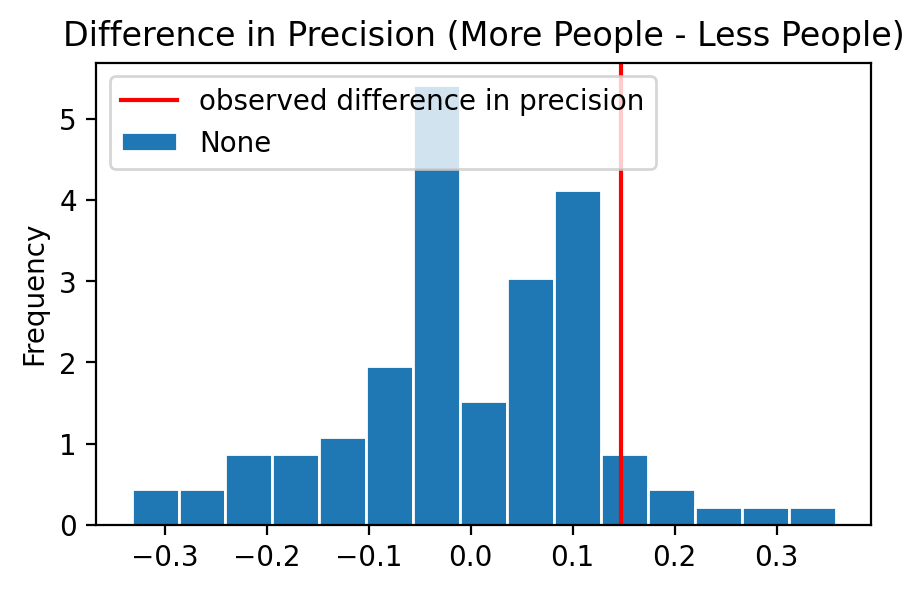

In [120]:
# TODO
from sklearn import metrics

more_affected = df['CUSTOMERS.AFFECTED'] >= df['CUSTOMERS.AFFECTED'].median() # Y

# Null Hypothesis: my model is fair; the the precision for my two subsets are roughly the same

# Alternative Hypothesis: my model is unfair; the precision for the old subset is higher than the young subset

results = X_test
results['more_affected'] = more_affected.replace({True: 'more', False: 'less'})
results['prediction'] = y_pred
results['cause'] = y_test

r1 = results[results['more_affected'] == 'more']
r2 = results[results['more_affected'] == 'less']
# print ('More affected people precision: ',
# metrics.precision_score(r1['prediction'], r1['cause'], average='weighted'), '\nLess affected people precision: ',metrics.precision_score(r2['prediction'], r2['cause'], average='weighted'))

obs = results.groupby('more_affected').apply(lambda x: metrics.precision_score(x['cause'], x['prediction'], average='weighted')).diff().iloc[-1]
print('Observed precision: ',obs)
diff_in_acc = []
for _ in range(100):
    s = (
        results[['more_affected', 'prediction', 'cause']]
        .assign(more_affected=results.more_affected.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('more_affected')
        .apply(lambda x: metrics.precision_score(x['cause'], x['prediction'], average='weighted'))
        .diff()
        .iloc[-1]
    )
    
    diff_in_acc.append(s)

plt.figure(figsize=(5, 3))
pd.Series(diff_in_acc).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Precision (More People - Less People)')
plt.axvline(x=obs, color='red', label='observed difference in precision')
plt.legend(loc='upper left');
